In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nmf_son.base import nmf_son
from nmf_son.other_vers import nmf_son_alt, update_wj_subgrad, update_wj_smoothing
from nmf_son.utils import save_results
np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def plot_scores(fscores, gscores, lambda_vals, reg_val):
    def plot_ax(ax, f, g, total):
        ax.plot(total, color='black', linewidth=3, label='total')
        ax.plot(f, color='cyan', linewidth=1.5, label='f')
        ax.plot(g, color='yellow', linewidth=1.5, label='g')
        ax.legend()

    total_score = fscores + lambda_vals * gscores
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'lambda = {reg_val}', fontsize=25)

    axs[0].set_yscale('log')
    plot_ax(axs[0], fscores, gscores, total_score)
    axs[0].set_title('log scale', fontsize=16)

    axs[1].set_yscale('log')
    plot_ax(axs[1], fscores - fscores[-1], gscores - gscores[-1], total_score - total_score[-1])
    axs[1].set_title('log(score - score*)', fontsize=16)

def plot_matrices(W, H, img_size, comparison_idxs):
    fig, axs = plt.subplots(2, len(comparison_idxs), figsize=(20, 10), sharey='row')

    for i, idx in enumerate(comparison_idxs):
        axs[0, i].plot(W[:, idx] / np.dot(W[:, idx], W[:, idx]))
        axs[0, i].set_title(f'W({idx+1})')

        h_idx_3d = H[idx, :].reshape(img_size, order='F')
        axs[1, i].plot(h_idx_3d)
        axs[1, i].set_title(f'H({idx+1})')

def plot_images(H, img_size, comparison_idxs):
    fig, axs = plt.subplots(1, len(comparison_idxs), figsize=(20, 10))

    for i, idx in enumerate(comparison_idxs):
        h_idx_3d = H[idx, :].reshape(img_size, order='F')

        axs[i].imshow(h_idx_3d)
        img = axs[i].imshow(h_idx_3d, cmap='gray')
        divider = make_axes_locatable(axs[i])

        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(img, cax=cax, orientation='vertical')
        axs[i].set_title(f'H({idx+1})')

In [3]:
X = np.load('../datasets/urban_small.npz')['X']
rank = 6

data = np.load(f'../saved_models/urban_small_r6_ini.npz')
ini_W = data['W']
ini_H = data['H']

reg = 2
save_filepath = '../saved_models/other_methods/urban_small_r{}_l{}_{}.npz'

In [4]:
aa_size = 2
max_iter = 3000

In [5]:
%%time
Wb_admm, Hb_admm, Wl_admm, Hl_admm, fscores_admm, gscores_admm, lambda_vals_admm = nmf_son(X, ini_W.copy(), ini_H.copy(), _lambda=reg, itermax=max_iter, verbose=False)

CPU times: user 7.45 s, sys: 253 ms, total: 7.7 s
Wall time: 1 s


In [6]:
%%time
Wb_subgrad, Hb_subgrad, Wl_subgrad, Hl_subgrad, fscores_subgrad, gscores_subgrad, lambda_vals_subgrad = nmf_son_alt(update_wj_subgrad, X, ini_W.copy(), ini_H.copy(), _lambda=reg, itermax=max_iter, verbose=False)

CPU times: user 3.32 s, sys: 1.45 s, total: 4.77 s
Wall time: 627 ms


In [7]:
%%time
Wb_sm, Hb_sm, Wl_sm, Hl_sm, fscores_sm, gscores_sm, lambda_vals_sm = nmf_son_alt(update_wj_smoothing, X, ini_W.copy(), ini_H.copy(), _lambda=reg, itermax=max_iter, verbose=False)

CPU times: user 3.02 s, sys: 1.57 s, total: 4.59 s
Wall time: 602 ms


In [8]:
save_results(save_filepath.format(rank, reg, 'admm'), Wb_admm, Hb_admm, Wl_admm, Hl_admm, fscores_admm, gscores_admm, lambda_vals_admm)
save_results(save_filepath.format(rank, reg, 'subgrad'), Wb_subgrad, Hb_subgrad, Wl_subgrad, Hl_subgrad, fscores_subgrad, gscores_subgrad, lambda_vals_subgrad)
save_results(save_filepath.format(rank, reg, 'smooth'), Wb_sm, Hb_sm, Wl_sm, Hl_sm, fscores_sm, gscores_sm, lambda_vals_sm)

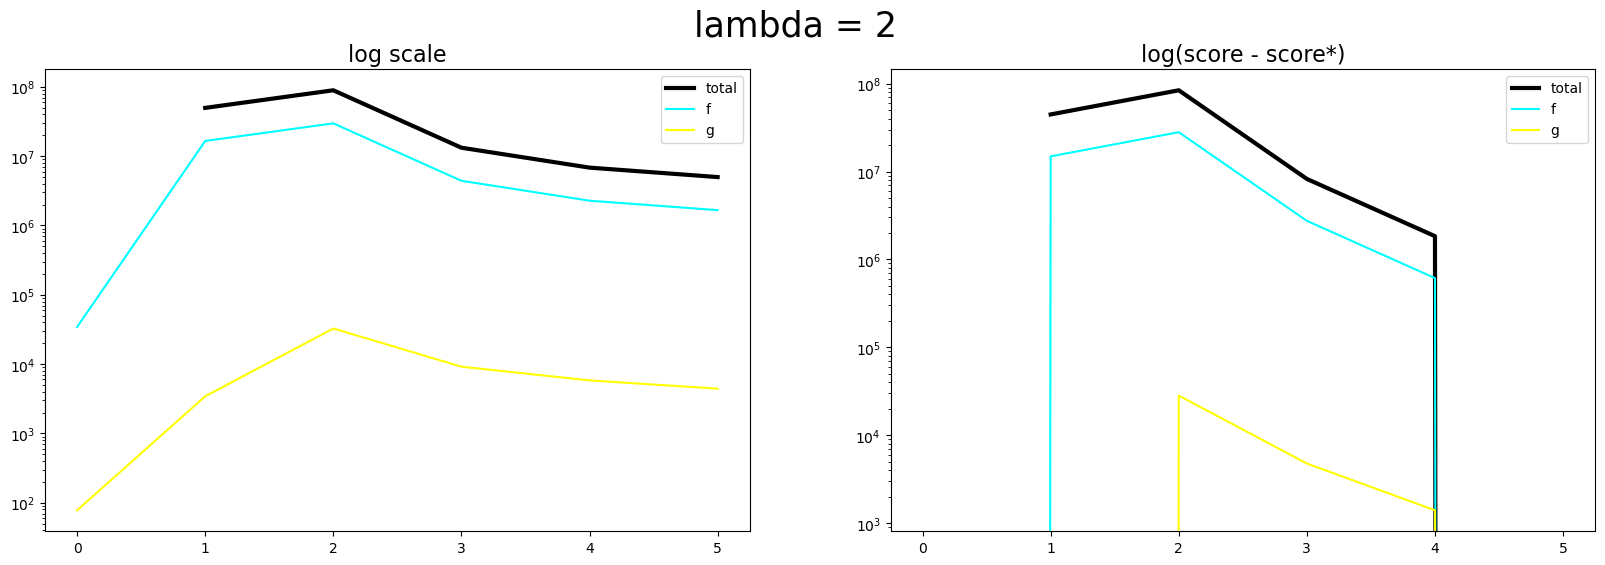

In [9]:
total_score_admm = fscores_admm + lambda_vals_admm * gscores_admm
total_score_subgrad = fscores_subgrad + lambda_vals_subgrad * gscores_subgrad
total_score_sm = fscores_sm + lambda_vals_sm * gscores_sm
plot_scores(fscores_admm, gscores_admm, lambda_vals_admm, reg)

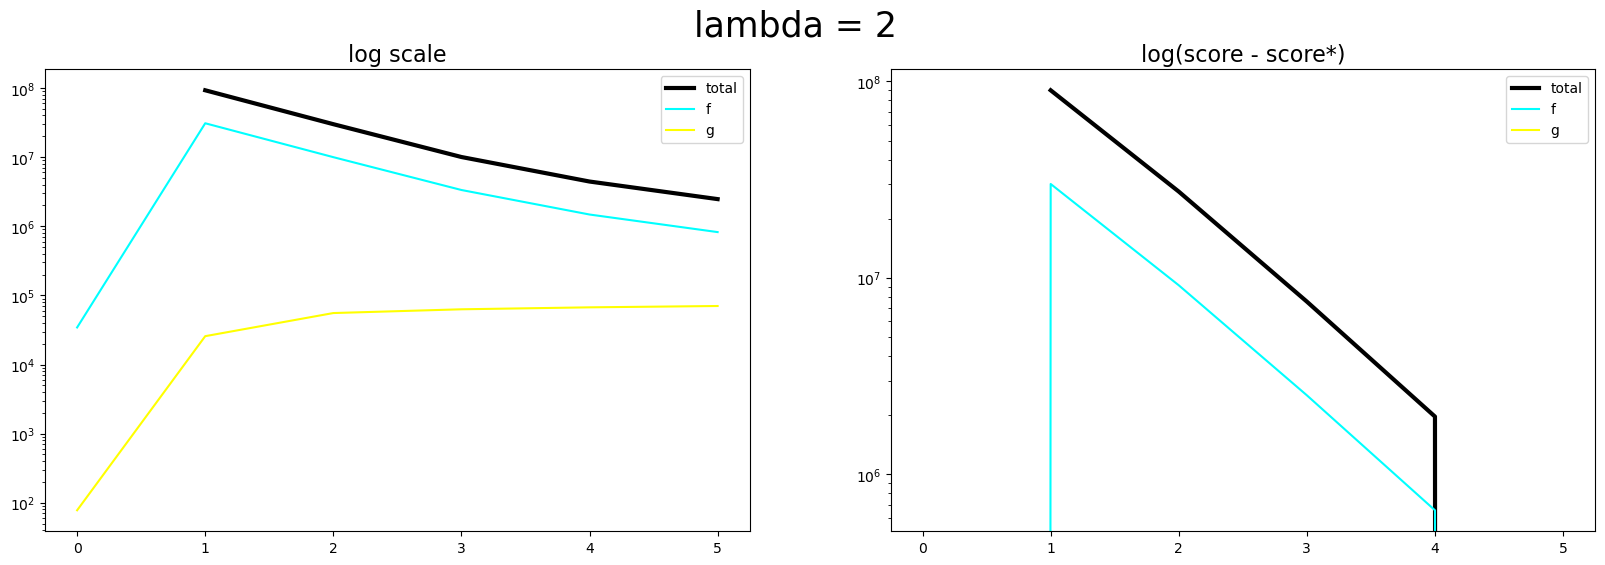

In [10]:
plot_scores(fscores_subgrad, gscores_subgrad, lambda_vals_subgrad, reg)

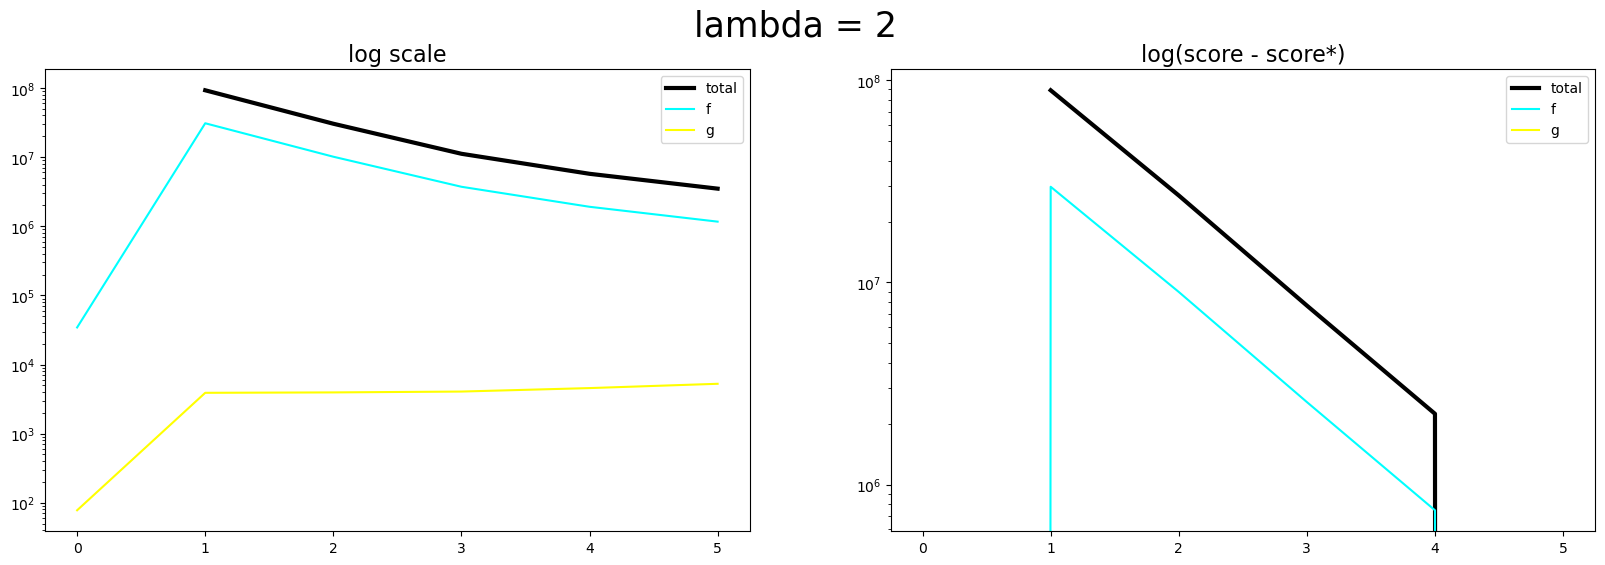

In [11]:
plot_scores(fscores_sm, gscores_sm, lambda_vals_sm, reg)